Below are the steps that are covered in this Machine Learning project walkthrough:

  1.  Importing the Data
  2.  Data Visualization
  3.  Data Cleaning and Transformation
  4.  Encoding the Data
  5.  Splitting the data into Training and Test sets
  6.  Fine Tuning Algorithms
  7.  Cross Validate with KFold
  8.  Prediction on the test set

### 1-Import Libraries and the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [4]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2-Data Visualization

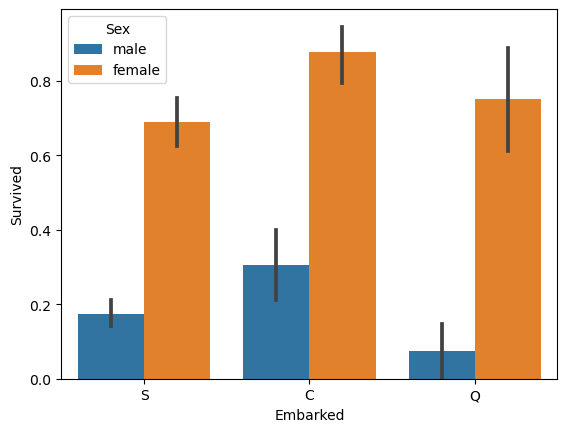

In [3]:
sns.barplot(x="Embarked",y="Survived",hue="Sex",data=data_train)
plt.show()

### 3-Data Cleaning and Transformation

The next step is to clean and transform data according to the output that we need. Here are the steps that I will consider in this step:

1. To avoid overfitting, I’m going to group people into logical human age groups.
2. Each booth begins with a letter. I bet this letter is much larger than the number that follows, let’s cut it off.
3. The Fare is another continuous value that should be simplified.
4. Extract the information from the “Name” function. Rather than using the full name, I extracted the last name and name prefix (Mr, Mrs etc.) and then added them as characteristics.
5. Finally, we need to remove unnecessary features.

In [5]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown','Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Ages = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df
data_train = transform_features(data_train)
data_test = transform_features(data_test)

/tmp/ipykernel_17693/121631915.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Ages = categories
/tmp/ipykernel_17693/121631915.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Ages = categories


In [6]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,22.0,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,38.0,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,26.0,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,35.0,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,35.0,0,0,2_quartile,N,"Allen,",Mr.


### 4-Encoding the Data

The next step is to standardize the labels. The Label encoder converts each unique string into a number, making the data more flexible that can be used for various algorithms. The result is a scary array of numbers for humans, but beautiful for machines:

In [7]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features],df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)

In [8]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,33,1,0,0,7,100,19
1,2,1,1,0,58,1,0,3,2,182,20
2,3,1,3,0,40,0,0,0,7,329,16
3,4,1,1,0,54,1,0,3,2,267,20
4,5,0,3,1,54,0,0,1,7,15,19


###   5-Splitting the data into Training and Test sets


The next step is to divide the data into training and testing sets. Here I’ll be using one variable to store all the features minus the value we want to predict, and the other variable to store only the value we want to predict.

For this task, I’m going to randomly mix this data into four variables. In this case, I train 80% of the data, then I test the remaining 20%:

In [10]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived','PassengerId'],axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test,random_state=23)

### 6-Fine Tuning Algorithms

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

#Choose the type of classifier
clf = RandomForestClassifier()

#Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9],
              'max_features': ['log2', 'sqrt', 'auto'],
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
              }

# Type of scoring used to campare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# set the clf(classifier) to the best combination of parameters
clf = grid_obj.best_estimator_

#Fit the best algorithm to the data
clf.fit(X_train, y_train)

/home/ali/miniconda3/envs/ali-gpu/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/ali/miniconda3/envs/ali-gpu/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/ali/miniconda3/envs/ali-gpu/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` o

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_leaf=5, n_estimators=6)

In [13]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test,predictions))

0.8044692737430168


###   7-Cross Validate with KFold

Now we need to use KFold cross-validation to validate our machine learning model. KFold cross-validation helps to understand that is our model good? This makes it possible to verify the efficiency of the algorithm using KFold. This will divide our data into 10 compartments, then run the algorithm using a different compartment as the test set for each iteration:

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

def run_kfold(clf, X_all, y_all):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))
    mean_outcome = np.mean(outcomes)
    print("Mean accuracy: {0}".format(mean_outcome))

# You need to pass X_all and y_all as arguments to run_kfold
run_kfold(clf, X_all, y_all)


Fold 1 accuracy: 0.7777777777777778
Fold 2 accuracy: 0.8426966292134831
Fold 3 accuracy: 0.797752808988764
Fold 4 accuracy: 0.8426966292134831
Fold 5 accuracy: 0.8539325842696629
Fold 6 accuracy: 0.8202247191011236
Fold 7 accuracy: 0.7528089887640449
Fold 8 accuracy: 0.7752808988764045
Fold 9 accuracy: 0.8651685393258427
Fold 10 accuracy: 0.8202247191011236
Mean accuracy: 0.8148564294631709


###   8-Prediction on the test set

Now we need to predict on the actual test data:

In [26]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))
output = pd.DataFrame({'PassengerId':ids, 'Survived':predictions})
output.head()

/home/ali/miniconda3/envs/ali-gpu/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


source website:  https://thecleverprogrammer.com/2020/12/18/machine-learning-project-walkthrough-with-python/#google_vignette